# CMSC 320 Final Project
<h1>How Hard Is It To Become NBA MVP? </h1> <h4> By Manan Bhalodia, Mohit Jauhri </h4>

<h3>Overview</h3>

Most of the American Population loves to watch the NBA! Each person has their own favorite player and follows them passionately. Over the years, the NBA has changed in terms of physicality and other factors. This tutorial will provide an in-depth analysis of NBA Players over the past 60 years. However, we will be looking at a subset of this data and specifically be looking at whether or not it has become harder to become MVP over the years.

The following link shows the dataset we will be using: https://www.kaggle.com/drgilermo/nba-players-stats. Specifically, we will be using a .csv file named Season_Stats.csv which contains all the data about hundreds of players. Another dataset we will be using represents MVP data: http://www.basketball-reference.com/awards/mvp.html
(this data contains all MVPs from 1956 to 2017 with their season stats).
<br/>
<br>The tutorial will be organized by the following Data Science pipeline we learned about throughout the course:</br>
    <br/>
    <br>Data Collection</br>
    <br>Data Processing</br>
    <br>Exploratory Data Analysis and Visualization</br>
    <br>Hypothesis Testing and Machine Learning</br>

<h3> Importing Libraries </h3>

In order to use certain functions, you will need to import libraries into the Python notebook. Below are some of the commons libraries that we use to complete actions such as plotting. To learn more about some of the common libraries you will use as a data scientist, refer to the links below: 
<br>https://seaborn.pydata.org/</br>
<br>https://pandas.pydata.org/</br>
<br>http://www.numpy.org/</br>
<br>http://scikit-learn.org/stable/</br>

In [60]:
import numpy as np
import pandas as pd
import requests 
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import seaborn as sb
from sklearn import linear_model
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Data Collection
## Player stats from 1950 - 2017

In [61]:
# get data for all the players from the seasons_stats file
df_all = pd.read_csv("Seasons_Stats.csv")

## Tidy This Data!

In [62]:
#NOTE: the year corresponds to the last year in the format 2000 - 2001. EX: If year said 2001 then the player
# started the season in 2000 and ended on 2001.

# Tidy data keeping only the columns we'll need.
df_all = df_all[["Unnamed: 0","Year","Player","Age","Tm","PER","FTr","TS%","TRB%","AST%","STL%","BLK%","TOV%","PTS"]]

# remove * at the end of some player names to create uniform format
df_all['Player'] = df_all['Player'].str.strip('*')

#rename Unnamed column to represent ID of Year and Player 
df_all = df_all.rename(index=str, columns={"Unnamed: 0": "YTID"})
df_all.head()

,YTID,Year,Player,Age,Tm,PER,FTr,TS%,TRB%,AST%,STL%,BLK%,TOV%,PTS
0,0,1950.0,Curly Armstrong,31.0,FTW,NaN,0.467,0.368,NaN,NaN,NaN,NaN,NaN,458.0
1,1,1950.0,Cliff Barker,29.0,INO,NaN,0.387,0.435,NaN,NaN,NaN,NaN,NaN,279.0
2,2,1950.0,Leo Barnhorst,25.0,CHS,NaN,0.259,0.394,NaN,NaN,NaN,NaN,NaN,438.0
3,3,1950.0,Ed Bartels,24.0,TOT,NaN,0.395,0.312,NaN,NaN,NaN,NaN,NaN,63.0
4,4,1950.0,Ed Bartels,24.0,DNN,NaN,0.378,0.308,NaN,NaN,NaN,NaN,NaN,59.0


Here we have one of our dataframes which shows a glance of our data of players from the 1950. In the 1950s, multiple stats were never recorded so they were filled with NaN.

Steps taken to tidy the data: 
1. keep only the relevant columns (Unnamed: 0, Year, Player, Age, Team, Player Effecieny Rating, Free Throw Rate, True Shooting %, Total Rebound %, Assist %, Steal %, Block %, Turnover %, and Points. 

2. Remove the * that is in the Player columns after the names of some players. 

3. Rename the "Unnamed: 0" column to have it represent a unique ID for Player and Year.

If you want to learn more about what these stats mean and more check out the NBA glossery: https://stats.nba.com/help/glossary/

## Player stats from players who started on and after 2000

In [63]:
df = df_all

# only keep players that started their career after 2000
players_remove = list (df[df.Year <= 2000].Player.unique())
df = df[~df['Player'].isin(players_remove)]
df = df[df.PER.notnull()]

df.head()

,YTID,Year,Player,Age,Tm,PER,FTr,TS%,TRB%,AST%,STL%,BLK%,TOV%,PTS
14971,14971,2001.0,Courtney Alexander,23.0,TOT,11.6,0.262,0.484,5.9,8.0,1.7,0.3,10.5,618.0
14972,14972,2001.0,Courtney Alexander,23.0,DAL,6.8,0.253,0.404,7.5,6.9,1.7,0.5,9.6,160.0
14973,14973,2001.0,Courtney Alexander,23.0,WAS,14.2,0.266,0.519,5.1,8.6,1.7,0.2,10.9,458.0
14987,14987,2001.0,Dalibor Bagaric,20.0,CHI,3.3,0.431,0.304,12.8,6.2,1.9,4.6,21.4,47.0
14989,14989,2001.0,Erick Barkley,22.0,POR,10.3,0.000,0.432,4.7,28.8,2.8,0.0,18.5,19.0


Here is another dataframe for which we utilize the data from the previous data, however, now we sort it so that it starts with players who began their careers in 2000 or later. This data frame will be important later on when there will be too many points so to reduce static from all points we will just show the trend for this subset of players. 

## MVP Data

In [64]:
# Use HTTP GET request library to get the NBA MVP Data from the URL
r = requests.get( "http://www.basketball-reference.com/awards/mvp.html" )

# Use Beautiful Soup to parse the HTML associated with the website  
soup = BeautifulSoup( r.content, 'html.parser')

data = []

# Use Beautiful Soup to find the table containing the relevant MVP data and store in an array
tbl = soup.find( "tbody")
rows = tbl.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols])

# Create a pandas dataframe object containing the NBA MVP data
df1 = pd.DataFrame(data)

# Display the dataframe
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,NBA,Russell Westbrook,(V),28,OKC,81,34.6,31.6,10.7,10.4,1.6,0.4,.425,.343,.845,13.1,.224
1,NBA,Stephen Curry,(V),27,GSW,79,34.2,30.1,5.4,6.7,2.1,0.2,.504,.454,.908,17.9,.318
2,NBA,Stephen Curry,(V),26,GSW,80,32.7,23.8,4.3,7.7,2.0,0.2,.487,.443,.914,15.7,.288
3,NBA,Kevin Durant,(V),25,OKC,81,38.5,32.0,7.4,5.5,1.3,0.7,.503,.391,.873,19.2,.295
4,NBA,LeBron James,(V),28,MIA,76,37.9,26.8,8.0,7.3,1.7,0.9,.565,.406,.753,19.3,.322
5,NBA,LeBron James,(V),27,MIA,62,37.5,27.1,7.9,6.2,1.9,0.8,.531,.362,.771,14.5,.298
6,NBA,Derrick Rose,(V),22,CHI,81,37.4,25.0,4.1,7.7,1.0,0.6,.445,.332,.858,13.1,.208
7,NBA,LeBron James,(V),25,CLE,76,39.0,29.7,7.3,8.6,1.6,1.0,.503,.333,.767,18.5,.299
8,NBA,LeBron James,(V),24,CLE,81,37.7,28.4,7.6,7.2,1.7,1.1,.489,.344,.780,20.3,.318
9,NBA,Kobe Bryant,(V),29,LAL,82,38.9,28.3,6.3,5.4,1.8,0.5,.459,.361,.840,13.8,.208


This is the dataframe for those players who won NBA MVP over the years of 1956 to 2017.

Link to learn more about this data: http://www.basketball-reference.com/awards/mvp.html

## Tidy This Data!

In [65]:
# Assign the dataframe variables the appropriate column labels
df1.columns = [ 'League','Player','voting','Age','Team','g','mp','pts','trb','ast','stl','blk','fg','3pt','ft','ws','WS/48']

# insert years for MVPs from 1956 to 2017 
df1.insert(0, 'Year', range(1956, 1956 + len(df1)))
df1["Year"] = df1["Year"].values[::-1]

# get only columns we will actually need
df1 = df1[["Year", "Player", "Age", "Team"]]

df1.head()

,Year,Player,Age,Team
0,2017,Russell Westbrook,28,OKC
1,2016,Stephen Curry,27,GSW
2,2015,Stephen Curry,26,GSW
3,2014,Kevin Durant,25,OKC
4,2013,LeBron James,28,MIA


In [66]:
# Create a data frame to join MVPs to their stats for that year they won. 
df_mvp = df1.merge(df_all, on=["Player", "Year"], how="inner")
df_mvp = df_mvp[['YTID','Year', 'Player', 'Age_y', 'Tm', 'PER',"FTr","TS%","TRB%","AST%","STL%","BLK%","TOV%",'PTS']]
df_mvp = df_mvp.rename(index=str, columns={"Age_y": "Age", "Tm": "Team"})
df_mvp

,YTID,Year,Player,Age,Team,PER,FTr,TS%,TRB%,AST%,STL%,BLK%,TOV%,PTS
0,24654,2017,Russell Westbrook,28.0,OKC,30.6,0.433,0.554,17.1,57.3,2.3,0.9,15.9,2558.0
1,23633,2016,Stephen Curry,27.0,GSW,31.5,0.250,0.669,8.6,33.7,3.0,0.4,12.9,2375.0
2,23000,2015,Stephen Curry,26.0,GSW,28.0,0.251,0.638,7.0,38.6,3.0,0.5,14.3,1900.0
3,22438,2014,Kevin Durant,25.0,OKC,29.8,0.477,0.635,10.8,26.7,1.7,1.5,12.2,2593.0
4,21933,2013,LeBron James,28.0,MIA,31.6,0.395,0.640,13.1,36.4,2.4,1.9,12.4,2036.0
5,21395,2012,LeBron James,27.0,MIA,30.7,0.429,0.605,12.6,33.6,2.6,1.7,13.3,1683.0
6,20991,2011,Derrick Rose,22.0,CHI,23.5,0.348,0.550,6.4,38.7,1.5,1.3,13.1,2026.0
7,20207,2010,LeBron James,25.0,CLE,31.1,0.506,0.604,11.1,41.8,2.2,2.0,12.3,2258.0
8,19611,2009,LeBron James,24.0,CLE,31.7,0.472,0.591,11.9,38.0,2.4,2.4,11.0,2304.0
9,18825,2008,Kobe Bryant,29.0,LAL,24.2,0.439,0.576,9.0,23.9,2.4,0.9,11.3,2323.0


Even though the MVP dataframe had stats for each mvp, we want to try and keep the data consistent by using one stats file and so we join the MVP players with their appropriate stats for that year from the main Player stats dataframe. 

<h3> Data Collection Steps </h3>
1. In order to retrieve the data for all the players, we need to use read_csv in order to read the input and print out the data. However, for the MVP players, we scrape this data with RESTFUL API queries using HTTP requests. This is a GET request, which performs a query and returns the HTML file data for the NBA MVP data.
2. After scraping and parsing the data, we need to tidy the data, so we will remove columns that we feel are unnecessary when performing data analysis. Also, we will edit/create new dataframes with respect to the data we are trying to display. 

## Data Frames so far: 
### 1. df_all - Contains data for all players through 1950 - 2017 
#### (YTID	Year Player	Age	Tm	PER	FTr	TS%	TRB%	AST%	STL%	BLK%	TOV%	PTS)
### 2. df - Contains data for all players who started after 2000
#### (YTID	Year Player	Age	Tm	PER	FTr	TS%	TRB%	AST%	STL%	BLK%	TOV%	PTS)
### 3. df1 - Contains data for who was MVP from 1956 - 2017
#### (Year	Player	Age	Team)
### 4. df_mvp - Contains data for all MVPs from 1956 - 2017 mapped with their player stats for that year 
#### (YTID	Year	Player	Age	Team	PER	PTS)

# Exploratory Data Analysis

The players in the dataset here aren't all included because since 1973 there were no 3 Pointers or other various stats that were kept track of. We take this into account by putting an NaN for those certain columns and will drop them from the dataframe when plotting these points. 

<h3> Steps </h3>
1. Based on the data provided, we will plot the data in multiple ways. The ones we chose to do here would be a scatter plot and violin plot with linear regression lines. 
2. We will then include a title for the plot and label its axis, letting the reader understand what the graph is trying to demonstrate. 

Note: There are two ways that we can plot this data. One way would be using matplotlib and the other way would be using Seaborn. These two are libraries that Python utilizes and its up to your personal preference on which one you would like to use. In this project, we have used Seaborn, which is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics. To learn more about these libraries, read the following links: 
1. https://seaborn.pydata.org/
2. http://matplotlib.org/

## Show PER of all players from 1950 to 2017

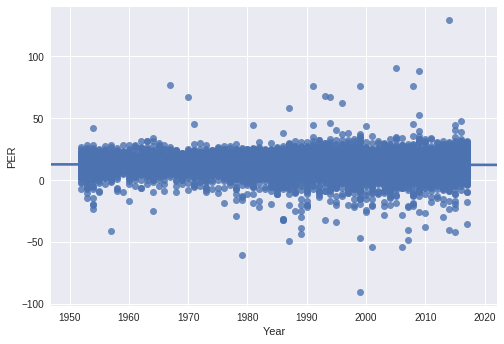

In [67]:
# Use Seaborn to plot all points of all players
sb.regplot(x="Year", y="PER", data=df_all)
plt.show()

The plot above is showing the Player Efficiency Rating of players over the past 60 years. As you can see, there are a few outliers in the data as some points show a player having a -100 PER or even 100 PER. The average which is represented by the linear regression line is pretty stable as it stays horizontal from 1950-2017 and players are always either above or under the line, showing that average PER is around 20. 

## Show PER of all MVP players

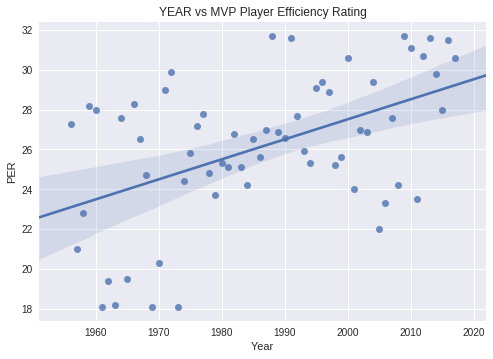

In [68]:
# get all unique names from the mvp players dataframe 
mvp_players = list (df_mvp.Player.unique())

#only show data from the df_all dataframe that contains data for the mvp players 
df_mvp_data = df_all[df_all['Player'].isin(mvp_players)]

# plot the year of MVP won and the PER or the player corresponding to that year
plt.title("YEAR vs MVP Player Efficiency Rating")
sb.regplot(x="Year", y="PER", data=df_mvp)
plt.show()

This plot shows that as the NBA has gone on over the years, the Player Efficiency Rating for MVP players has increased over the past 60 years. Specifically, the PER has increased linearly for MVP's and is shown by a positive increase in the linear regression line. As the game has changed over the years, it has turned into a more offensive showing and less defense. This is represented in the Player Efficiency Rating is mostly determined by offensive measures. To read more about how the PER is calculated please refer to the following link: https://www.basketball-reference.com/about/per.html. 

Lets continue our analysis and see what specific stats are needed to become an MVP!

## Violin Plot of Year vs PER
### Only showing all players who started after 2000 to clearly show that the PER of the average player has been consistent
## <font color="blue">*Blue dot </font> indicates PER of MVP for that year

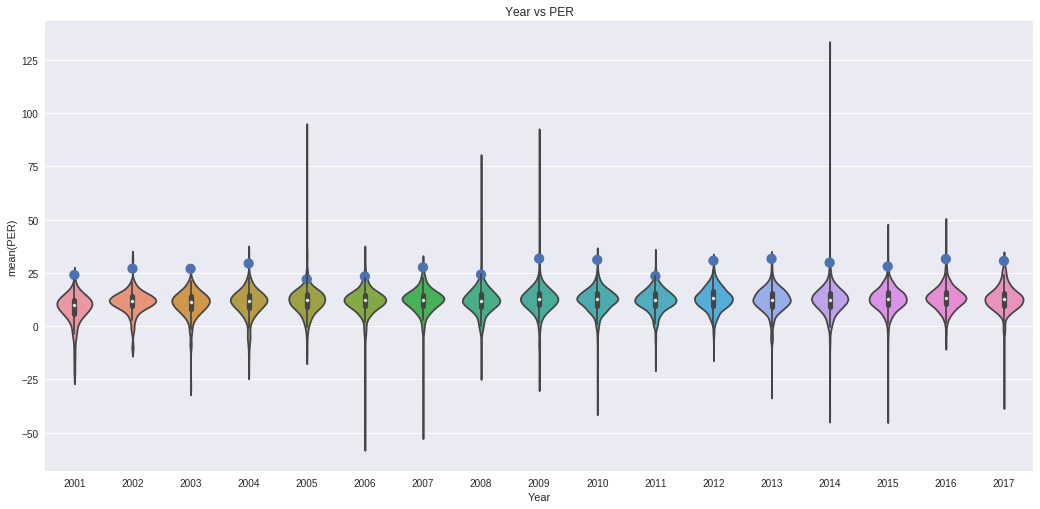

In [69]:
#get data for MVPs after 2000
df_mvp_new = df_mvp[df_mvp['Year'] >= 2001]
fig, ax = plt.subplots()

# increase the size of plot
fig.set_size_inches(17.7, 8.27)

#plot a violin plot of year vs PER and show where the MVP falls each year with a blue dot.
plt.title("Year vs PER")
sb.violinplot(x = "Year", y = "PER", data = df, ax=ax)

#Plot the MVP points 
sb.pointplot("Year", "PER", data=df_mvp_new, join=False,n_boot=10, ax=ax)
plt.show()

The violin plot above demonstrates that the PER has fluctuated over the years, but of late shows an increase in the PER of the MVP. As mentioned above, the blue dot represents the MVP's PER and shows that most of the players who have been a recipient of the MVP award have the highest Player Efficiency Rating in the season.

## Trend of MVP PER from 1956 to 2017

### <font color="orange">Linear fit line for all players</font>
### <font color="red">Linear fit line for MVP players</font>

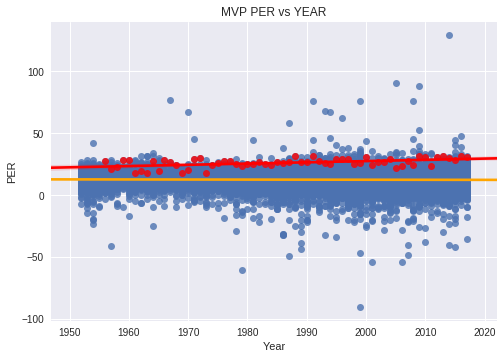

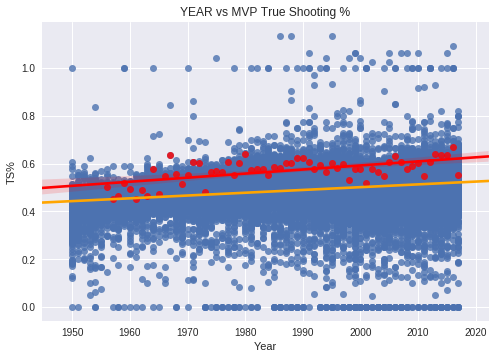

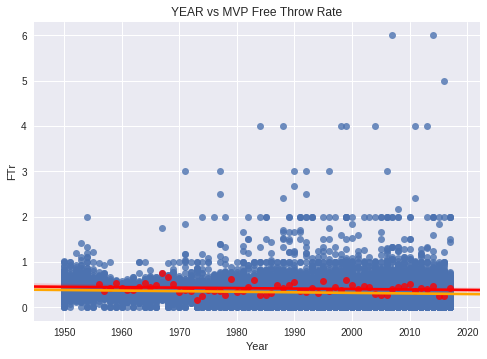

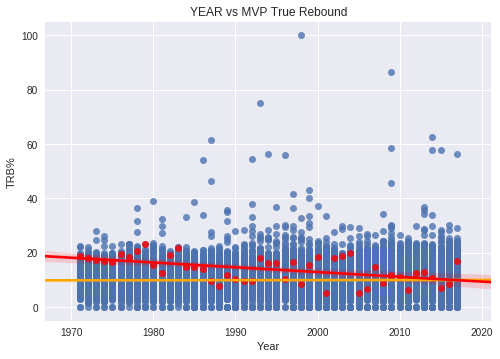

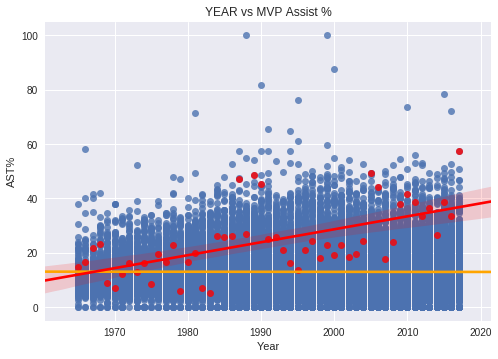

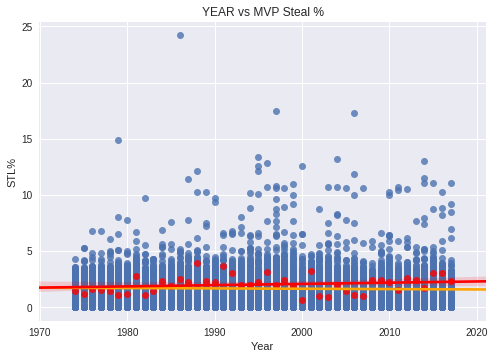

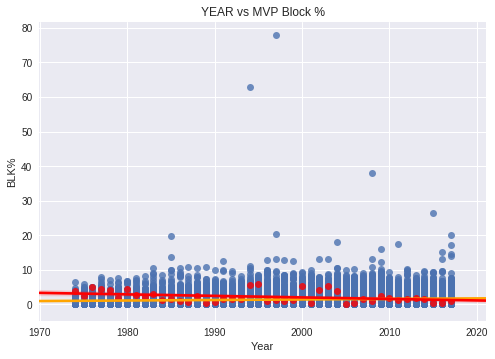

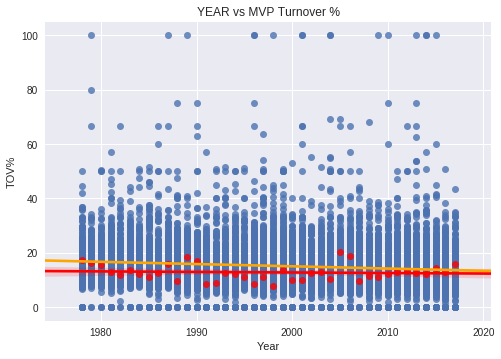

In [70]:
#Plot statistic vs year for all relevant statistics and show linear fit for the MVPs and for all players 

plt.title("MVP PER vs YEAR")
sb.regplot(x="Year", y="PER", data=df_all, line_kws={'color':'orange'})
sb.regplot(x="Year", y="PER", color="red", data=df_mvp)
plt.show()

plt.title("YEAR vs MVP True Shooting %")
sb.regplot(x="Year", y="TS%", data=df_all, line_kws={'color':'orange'})
sb.regplot(x="Year", y="TS%", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Free Throw Rate")
sb.regplot(x="Year", y="FTr", data=df_all, line_kws={'color':'orange'})
sb.regplot(x="Year", y="FTr", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP True Rebound")
sb.regplot(x="Year", y="TRB%", data=df_all, line_kws={'color':'orange'})
sb.regplot(x="Year", y="TRB%", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Assist %")
sb.regplot(x="Year", y="AST%", data=df_all, line_kws={'color':'orange'})
sb.regplot(x="Year", y="AST%", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Steal %")
sb.regplot(x="Year", y="STL%", data=df_all, line_kws={'color':'orange'})
sb.regplot(x="Year", y="STL%", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Block %")
sb.regplot(x="Year", y="BLK%", data=df_all, line_kws={'color':'orange'})
sb.regplot(x="Year", y="BLK%", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Turnover %")
sb.regplot(x="Year", y="TOV%", data=df_all, line_kws={'color':'orange'})
sb.regplot(x="Year", y="TOV%", data=df_mvp, color = "red")
plt.show()

The data displayed above here shows the data for hundreds of NBA players and shows how the MVP's compare to them. The red line represents the MVP's while the orange line shows the regular NBA players. Overall, it shows that MVP winners tend to have better statistics than others which makes sense, but for some statistics it actually shows the decline in some of these categories over the years for the MVP's as time goes on. In particular, the decline occurs in categories such as Turnovers, Blocks, Rebounds, and Free Throw Rate, which are all defensive stats. This shows that, indeed, it seems like the MVP for each year is leaning toward more offensive players. We see that stats for assists and true shooting percentage are steady, increasing only slightly; however for MVPs these stats are increasing at a faster rate. 

## Plot the difference in the MVPs stats and the average for that stat and year

In [71]:
# find average of the stats for each year and put it in the mvp dataframe
AVG_PER = []
AVG_FTr = []
AVG_TS = []
AVG_TRB = []
AVG_AST = []
AVG_STL = []
AVG_BLK = []
AVG_TOV = []
for index, row in df_mvp.iterrows():
    year = row['Year']
    df_year = df_all[df_all['Year'] == year]
    AVG_PER.append(df_year['PER'].mean())
    AVG_FTr.append(df_year['FTr'].mean())
    AVG_TS.append(df_year['TS%'].mean())
    AVG_TRB.append(df_year['TRB%'].mean())
    AVG_AST.append(df_year['AST%'].mean())
    AVG_STL.append(df_year['STL%'].mean())
    AVG_BLK.append(df_year['BLK%'].mean())
    AVG_TOV.append(df_year['TOV%'].mean())

In [72]:
# calculate the difference in the stats from what that mvp had to the average of that year and store it in a new column

df_mvp['AVG_PER'] = AVG_PER
df_mvp['AVG_FTr'] = AVG_FTr
df_mvp['AVG_TS%'] = AVG_TS
df_mvp['AVG_TRB%'] = AVG_TRB
df_mvp['AVG_AST%'] = AVG_AST
df_mvp['AVG_STL%'] = AVG_STL
df_mvp['AVG_BLK%'] = AVG_BLK
df_mvp['AVG_TOV%'] = AVG_TOV

df_mvp['DIF_PER'] = df_mvp['PER'] - df_mvp['AVG_PER']
df_mvp['DIF_FTr'] = df_mvp['FTr'] - df_mvp['AVG_FTr']
df_mvp['DIF_TS%'] = df_mvp['TS%'] - df_mvp['AVG_TS%']
df_mvp['DIF_TRB%'] = df_mvp['TRB%'] - df_mvp['AVG_TRB%']
df_mvp['DIF_AST%'] = df_mvp['AST%'] - df_mvp['AVG_AST%']
df_mvp['DIF_STL%'] = df_mvp['STL%'] - df_mvp['AVG_STL%']
df_mvp['DIF_BLK%'] = df_mvp['BLK%'] - df_mvp['AVG_BLK%']
df_mvp['DIF_TOV%'] = df_mvp['TOV%'] - df_mvp['AVG_TOV%']

df_mvp

,YTID,Year,Player,Age,Team,PER,FTr,TS%,TRB%,AST%,...,AVG_BLK%,AVG_TOV%,DIF_PER,DIF_FTr,DIF_TS%,DIF_TRB%,DIF_AST%,DIF_STL%,DIF_BLK%,DIF_TOV%
0,24654,2017,Russell Westbrook,28.0,OKC,30.6,0.433,0.554,17.1,57.3,...,1.684538,12.891906,17.871429,0.162509,0.027201,7.068571,44.528739,0.765210,-0.784538,3.008094
1,23633,2016,Stephen Curry,27.0,GSW,31.5,0.250,0.669,8.6,33.7,...,1.611419,13.321391,18.281834,-0.036221,0.145600,-1.215225,20.467647,1.415744,-1.211419,-0.421391
2,23000,2015,Stephen Curry,26.0,GSW,28.0,0.251,0.638,7.0,38.6,...,1.502151,13.619846,15.450845,-0.014861,0.132026,-2.646697,24.992780,1.374501,-1.002151,0.680154
3,22438,2014,Kevin Durant,25.0,OKC,29.8,0.477,0.635,10.8,26.7,...,1.505237,14.385149,17.599182,0.184268,0.128291,0.815548,14.334534,0.113257,-0.005237,-2.185149
4,21933,2013,LeBron James,28.0,MIA,31.6,0.395,0.640,13.1,36.4,...,1.583042,14.621404,19.472028,0.116998,0.140691,3.123951,23.377098,0.820105,0.316958,-2.221404
5,21395,2012,LeBron James,27.0,MIA,30.7,0.429,0.605,12.6,33.6,...,1.725590,14.644465,17.968058,0.147584,0.103506,2.502359,20.913249,0.937387,-0.025590,-1.344465
6,20991,2011,Derrick Rose,22.0,CHI,23.5,0.348,0.550,6.4,38.7,...,1.623520,14.167203,11.300160,0.043539,0.038895,-3.469760,26.272800,-0.016960,-0.323520,-1.067203
7,20207,2010,LeBron James,25.0,CLE,31.1,0.506,0.604,11.1,41.8,...,1.562392,13.936458,18.652860,0.197819,0.091346,1.037088,29.581976,0.645061,0.437608,-1.636458
8,19611,2009,LeBron James,24.0,CLE,31.7,0.472,0.591,11.9,38.0,...,1.700000,13.826425,18.976460,0.171573,0.075908,1.417010,26.095704,0.910309,0.700000,-2.826425
9,18825,2008,Kobe Bryant,29.0,LAL,24.2,0.439,0.576,9.0,23.9,...,1.669024,13.893761,12.165993,0.125948,0.073059,-1.090741,11.742256,0.943771,-0.769024,-2.593761


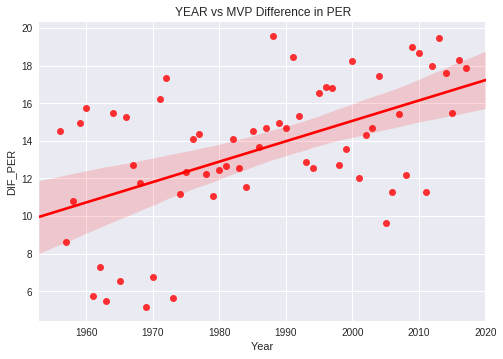

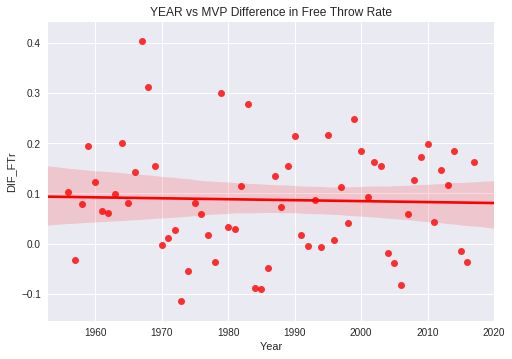

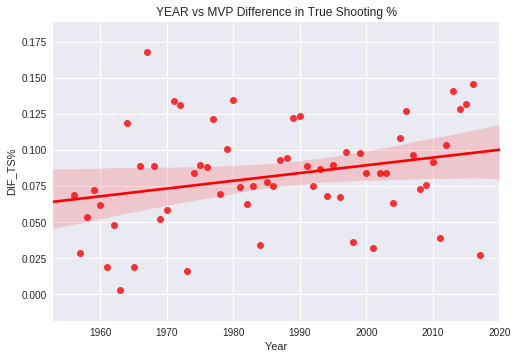

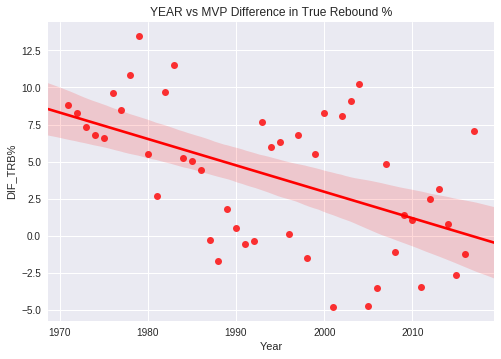

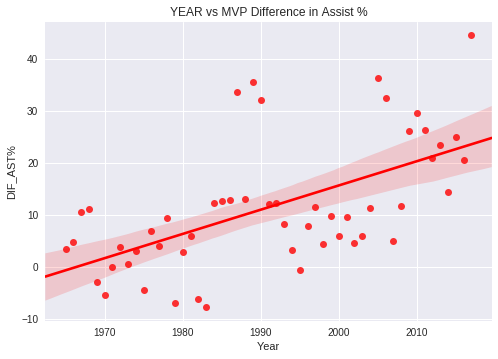

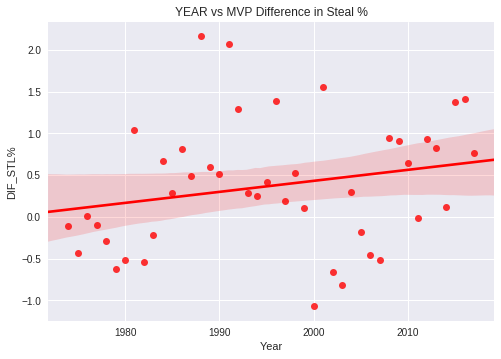

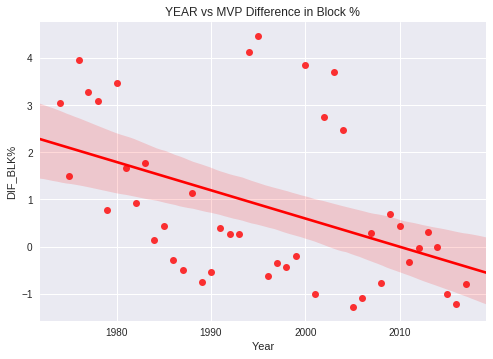

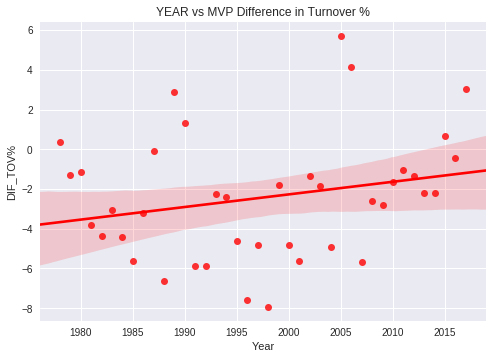

In [73]:
#Plot the difference in stats for each year of MVP compared to average using the new column we created

plt.title("YEAR vs MVP Difference in PER")
sb.regplot(x="Year", y="DIF_PER", color="red", data=df_mvp)
plt.show()

plt.title("YEAR vs MVP Difference in Free Throw Rate")
sb.regplot(x="Year", y="DIF_FTr", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Difference in True Shooting %")
sb.regplot(x="Year", y="DIF_TS%", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Difference in True Rebound %")
sb.regplot(x="Year", y="DIF_TRB%", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Difference in Assist %")
sb.regplot(x="Year", y="DIF_AST%", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Difference in Steal %")
sb.regplot(x="Year", y="DIF_STL%", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Difference in Block %")
sb.regplot(x="Year", y="DIF_BLK%", data=df_mvp, color = "red")
plt.show()

plt.title("YEAR vs MVP Difference in Turnover %")
sb.regplot(x="Year", y="DIF_TOV%", data=df_mvp, color = "red")
plt.show()

The following graphs show a deeper trend of the difference of the MVP's stats minus the average of that year. We have plotted this for each key statistic that we believe is important. As you can see, there is an increasing, positive trend in general PER over the years, True Shooting %, Assist %, Steal %, and Turnover %. Meanwhile, there is negative trend for Block %, True Rebound %, and Free Throw Rate.

# Machine Learning
## Use Regression models to show predicted values 
### Predict PER till 2024

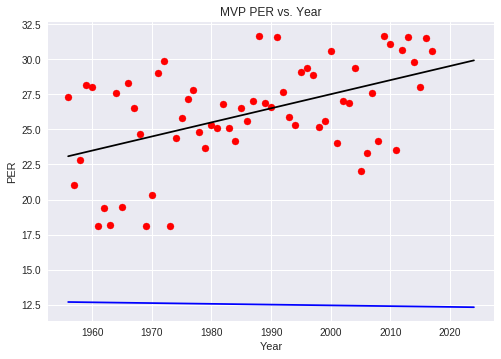

array([ 0.10064466])

In [74]:
# 1) Define the X and Y axises for the regression function
X = df_mvp['Year'].values[:,np.newaxis]
Y = df_mvp['PER'].values

#1.1) Define X and Y for the regression function of all players
df_all = df_all[df_all.PER.notnull()]
X2 = df_all['Year'].values[:,np.newaxis]
Y2 = df_all['PER'].values

# 2) Create a new Linear Regression Object and fit the model
model = LinearRegression()
model.fit(X, Y)

#2.1) Create linear regression model for all players
model2 = LinearRegression()
model2.fit(X2, Y2)

# 3) Title and set up the graph with labels
plt.title('MVP PER vs. Year')
plt.xlabel("Year")
plt.ylabel("PER")
plt.scatter(X, Y,color='r')

temp = []
#4) Add more years into the future to predict future PER values 
for i in range(1956, 2025) :
    temp.append([i])


# 5) Plot the regression graph and show the model
plt.plot(temp, model.predict(temp),color='k')
#5.1) Plot the regression model for all players 
plt.plot(temp, model2.predict(temp),color='b')
plt.show()
model.coef_

This graph shows that over time its getting harder to become MVP because the stats for PER are getting harder. The black line is the MVP predictions through 2024 and the blue line is all the players PER predictions till 2024. The plotted points(represented in the red points) are simply just the MVP player's data. 

## OLS Regression Stats

In [76]:
x2 = sm.add_constant(X)
lm = sm.OLS(Y, x2)
fit = lm.fit()
print(fit.summary())
print ("Linear Regression: y = {0}x + {1}".format(model.coef_, model.intercept_))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     19.48
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           4.30e-05
Time:                        10:14:29   Log-Likelihood:                -159.32
No. Observations:                  62   AIC:                             322.6
Df Residuals:                      60   BIC:                             326.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -173.7742     45.297     -3.836      0.0

In [77]:
print ("Linear Regression: y = {0}x + {1}".format(model.coef_, model.intercept_))
x3 = sm.add_constant(X2)
lm = sm.OLS(Y2, x3)
fit = lm.fit()
print(fit.summary())

Linear Regression: y = [ 0.10064466]x + -173.77416081186578
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.358
Date:                Sat, 16 Dec 2017   Prob (F-statistic):             0.0206
Time:                        10:15:13   Log-Likelihood:                -77534.
No. Observations:               24101   AIC:                         1.551e+05
Df Residuals:                   24099   BIC:                         1.551e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

## OLS Regression Stats - What does this mean?!
Here we also get the OLS Regression Results above for both lines. The first one is for the dataframe of the MVP's while the second results table is for all the players. An eye-opening stat is that for the dataframe of all player, the R-squared value is 0.0. This is mainly because there were so many players in the dataset that there are a number of factors to account for. For instance, there were many players who got injured during a whole season or even for a portion of the season and it would've affected their PER. Also, as stated before, some stats had changed since the 1960s and even weren't accounted for it till later, making it reasonable for the R-squared value to yield a value of 0.0.

<h3> Machine Learning </h3> 

We essentially are using hypothesis testing here to see if we can find a model that accurately represents the data. In this case, we want to test to see if it is harder to become MVP in the current NBA and the future compared to the past as the states for Player Efficiency Rating is increasing for MVP while remaining relatively steady for all other players. There are multiple ways to to test a hypothesis, but we are using the R^2 score. R-squared is a statistical measure of how close the data are to the fitted regression line. The best possible  R^2 score is 1, and the worst is 0. Our R^2 is 0.245 which is not a great fit, but nonetheless still a good fit. It was possibly this low due to the many factors that we may have no accounted for such as if a certain player was injured and they did not play for many games but the games they did play for they might have had a high PER. 

Note: For more information about R^2, check out this link: http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

Steps to Perform Machine Learning: 
    <br/>
    <br/>
    1) X and Y values must be defined in order to be able to perform machine learning. Here we will be measuring the PER vs Year for both MVP's and other NBA players.  
    <br/>
    2) We will create a linear regression object in order to be able to perform the regression.
    <br/>
    <br/>
    3) Plot the graph and show the slopes coefficient.
    <br/>
    <br/>
        Note: When plotting the graph please label the y and x axis as well create a title for the graph so that it is easily understandable for someone who would be looking at this graph. 

<h3> Conclusion </h3>

Knowing how the Player Efficiency Rating is used to determine the MVP of the NBA Season, we statistically showed how hard it has become to earn the conveted MVP status in the modern NBA. This is simply an example of how data science can be applied to some of your interests. There is so much data around us, it's just what you do with it and where your mind takes you. 

The dataset definitely has many other aspects that you can use if you are specifically interested in taking a look at something particular. For our purposes, it helped us realize that the game is trending towards a more attack first mentality rather than all-around game as offensive statistics are valued more than those who are defensive-minded players. You can see that their PER will be lower than those who are more offensive-minded or even all-around players. 

Overall, this tutorial lets you run through the complete data science pipeline as you learned many things from scraping data to performing ML algorithms in order to see a trend and the future predictions for statistics pertaining to NBA players and NBA MVP's. 

By all means, please use this dataset that we have used and play around with it for your own use!

<h3> References </h3>
Below are references related to Python/Data Science: 
1. Pandas: https://pandas.pydata.org/ 
2. Numpy: http://www.numpy.org/ 
3. Scikit-Learn: http://scikit-learn.org/stable/
4. Seaborn: https://seaborn.pydata.org/
5. Matplotlib: http://matplotlib.org/
6. R-Squared: http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

Below are references related to the NBA and PER:
1. About PER: https://www.basketball-reference.com/about/per.html
2. MVP Data: https://www.basketball-reference.com/awards/mvp.html
3. NBA Players Data: https://www.kaggle.com/drgilermo/nba-players-stats
